In [257]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [258]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [259]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    torch.nn.utils.clip_grad_value_(model.parameters(), 2)
    optimizer.step(closure)  

In [260]:
Phi_0 = torch.Tensor(np.loadtxt("file.txt")).reshape(200,1)
Phi_0.shape

torch.Size([200, 1])

In [261]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
global Phi_0

V = lambda r: -(Z*e**2)/r
Phi_aux = lambda r: r*torch.exp(-beta*r) * model.forward(r)
Phi_t = lambda r: Phi_aux(r) - Phi_0*torch.trapezoid(Phi_0[100:]*Phi_aux(r)[100:], r[100:],dim=0)

In [262]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data)

In [263]:
def loss_fn(r):
    r.requires_grad = True
    
    Phi = Phi_t(r)    
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=0 to 6

    prom = Phi.size()[0]
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [264]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 50000
lr1 = 2e-2
lr2 = 4e-3 
Phis_t = []
Es = []
lss = []
epochs = []

#Phi_0 = Phi_0/torch.sqrt(torch.trapezoid(Phi_0[100:]**2,R_train[100:],dim=0))


start = time.time()

model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr1)
for t in range(int(epoch/2)):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)    
optimizer = torch.optim.Adam(model.parameters(), lr=lr2)
for t in range(int(epoch/2)+1,epoch):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)
Es = np.squeeze(Es)
lss = np.squeeze(lss)
Phis_t = np.squeeze(Phis_t)
print("Done!")

end = time.time()
print(end - start)

Epoch 1
 ---------------------- loss: tensor([94346000.], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([91088512.], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([88542320.], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([85980416.], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([83022592.], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([79196112.], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([73666320.], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([64605028.], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([46580516.], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([8406414.], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([2.1809e+08], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([1.4553e+08], grad_fn=<DivBackward0>)
Epoch 13
 --

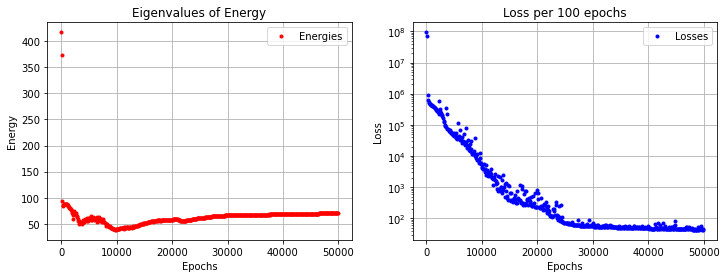

In [265]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, Es, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs, lss, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

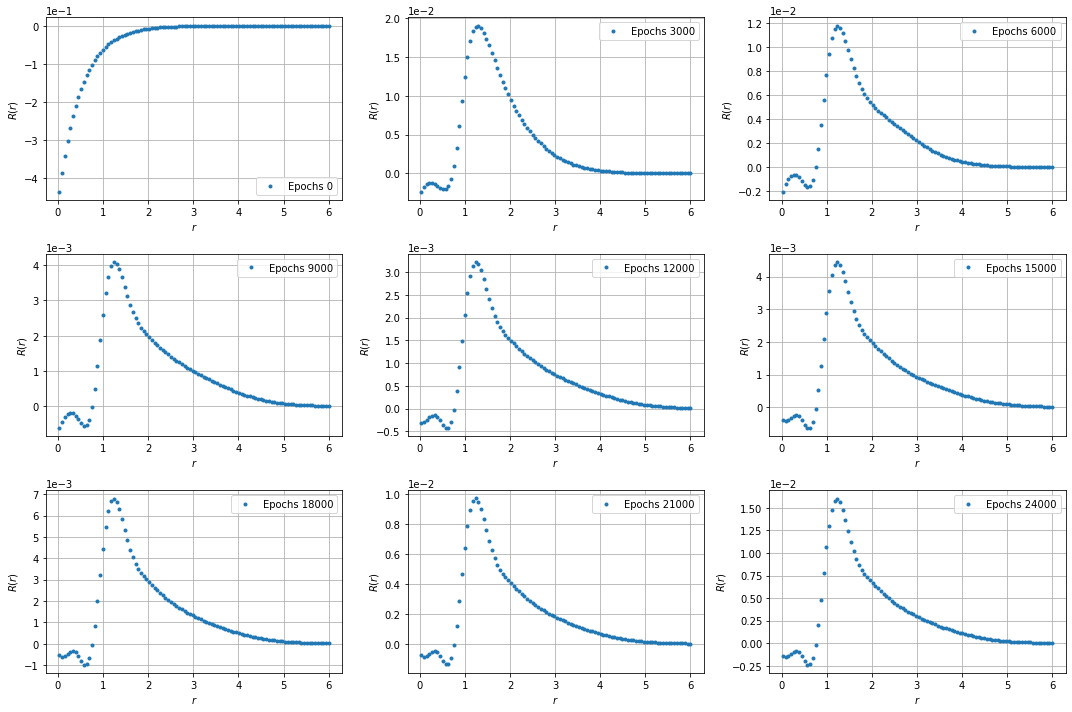

In [266]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(0,9):
    yy = Phis_t[30*i]
    yy = yy.reshape((200,1))
    axs[fil,col].plot(rr[100:], np.divide(yy[100:], rr[100:]), ".", label=f"Epochs {epochs[30*i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$R(r)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[fil,col].grid()
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.tight_layout()
plt.show()  

In [267]:
Es

array([417.0425  , 373.4908  ,  93.51079 ,  84.12531 ,  86.279816,
        87.800674,  88.5741  ,  88.71811 ,  88.41326 ,  87.842865,
        87.096405,  86.19436 ,  85.1453  ,  83.96396 ,  82.66799 ,
        81.267876,  79.76215 ,  78.120674,  76.27975 ,  74.11445 ,
        71.36499 ,  67.32537 ,  58.90406 ,  74.98961 ,  72.45149 ,
        70.65886 ,  69.81313 ,  67.82049 ,  65.32993 ,  62.458687,
        58.99913 ,  54.77701 ,  54.959908,  50.612198,  51.30074 ,
        51.958683,  53.6267  ,  51.26267 ,  49.563244,  57.240826,
        54.761616,  54.007034,  53.062424,  60.08509 ,  57.68785 ,
        56.7409  ,  55.377487,  61.181175,  56.572784,  54.585594,
        62.031013,  60.814873,  58.96622 ,  56.494846,  65.2654  ,
        59.87627 ,  57.085705,  61.308407,  62.758175,  59.89    ,
        56.554073,  61.552868,  60.97009 ,  57.608643,  53.750896,
        62.522865,  58.812714,  55.26071 ,  62.32733 ,  58.5081  ,
        55.19468 ,  59.15895 ,  58.94186 ,  55.76502 ,  53.477

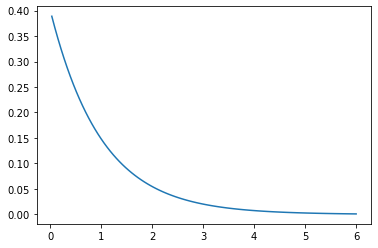

In [268]:
plt.plot(R_train.detach().numpy()[100:],Phi_0[100:]/R_train.detach().numpy()[100:])